# Data Science Challenge

**Objetivo: Desarrollar un script en Python que utilice aprendizaje automático para predecir si un cliente presentará un reclamo de seguro en el próximo año.**

Descripción: La compañía aseguradora está interesada en predecir si un cliente presentará un reclamo de seguro en el próximo año para poder tomar medidas preventivas y mejorar la satisfacción del cliente. La compañía ha recopilado datos históricos de clientes y reclamos y quiere utilizarlos para desarrollar un modelo de aprendizaje automático que pueda predecir si un cliente presentará un reclamo de seguro en el próximo año.

## Instalar las dependencias

In [1]:
#!pip install -r requirements.txt

In [2]:
#!pip install pycaret

# Entendimiento inicial de los datos

## Cargar Librerias

In [3]:
# %matplotlib inline

import re
import random
from collections import Counter

import numpy as np
import pandas as pd

from scipy.stats import kstest

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore")

#from pycaret.classification import *
#import shap

## Definición de funciones

In [4]:
def fx_porc_missings(data, only_missings = False):
    """Calcula los porcentajes de valores vacios en cada variable"""
    
    df_vars_missings = pd.concat([pd.DataFrame(data.isnull().sum(), columns = ['n_nulos']),
           pd.DataFrame(100*data.isnull().sum()/len(data), columns = ['%Total'])], axis = 1)
    if only_missings:
        return(df_vars_missings[df_vars_missings["n_nulos"]!=0])
    else:
        return(df_vars_missings)


## Lectura y validación de datos

In [5]:
# Ruta donde se encuentra alojado el dataset del caso
url_data='../data/'

In [6]:
# Lectura y carga de la data
df=pd.read_csv(url_data+'datos_de_prueba.csv', na_values='?', low_memory=False)

In [7]:
# Validar la correcta lectura del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   ID del cliente                3000 non-null   int64 
 1   Sexo                          3000 non-null   object
 2   Edad                          3000 non-null   int64 
 3   Ingresos                      3000 non-null   int64 
 4   Tipo de hogar                 3000 non-null   object
 5   Estado civil                  3000 non-null   object
 6   Número de hijos               3000 non-null   int64 
 7   Puntuación de crédito         3000 non-null   int64 
 8   Tipo de trabajo               3000 non-null   object
 9   Educación                     3000 non-null   object
 10  Fecha de inicio de la póliza  3000 non-null   object
 11  Tipo de seguro                3000 non-null   object
 12  Monto del seguro              3000 non-null   int64 
 13  Fecha del reclamo 

Se observa que se tienen 3000 filas y 15 columnas de los tipos int64(7), object(8). Se tiene que modificar el tipo de dato de las variables: ID de cliente, Fecha de inicio de la póliza, Fecha del reclamo para su posterior tratamiento.

**No se tienen valores vacios.**

In [8]:
# Mostrar los 5 primeros registros
df.head(5)

,ID del cliente,Sexo,Edad,Ingresos,Tipo de hogar,Estado civil,Número de hijos,Puntuación de crédito,Tipo de trabajo,Educación,Fecha de inicio de la póliza,Tipo de seguro,Monto del seguro,Fecha del reclamo,Monto del reclamo
0,1,Femenino,28,558900,Departamento,Viudo,3,556,Empresario,Preparatoria,2022-03-28,Vida,1806,2022-11-14,558
1,2,Femenino,18,212925,Departamento,Viudo,1,330,Empleado,Posgrado,2022-09-15,Vida,1371,2022-04-25,922
2,3,Femenino,37,838328,Departamento,Casado,3,776,Empresario,Universidad,2022-03-18,Hogar,6751,2022-07-31,3128
3,4,Masculino,25,459616,Casa,Soltero,4,821,Independiente,Universidad,2022-11-14,Hogar,5448,2022-07-29,1493
4,5,Masculino,41,678250,Casa,Casado,4,580,Empresario,Universidad,2023-03-02,Vida,5625,2022-07-08,1907


## Estudiar las dimensiones del dataset

In [9]:
df.shape

(3000, 15)

Se tienen 3000 filas y 15 columnas

In [10]:
df.size

45000

In [11]:
df['ID del cliente'].value_counts()

1       1
2004    1
1995    1
1996    1
1997    1
       ..
1003    1
1004    1
1005    1
1006    1
3000    1
Name: ID del cliente, Length: 3000, dtype: int64

El ID correspondiente al análisis es el ID del cliente, se aprecia que cada ID es único por lo que **cada fila corresponde a un único cliente o reclamo histórico.**

## Evaluar el tipo de problema

Vemos que es un caso de aprendizaje supervisado de clasificación para predecir si un cliente presentará un reclamo de seguro en el próximo año.

In [12]:
df.head(3)

,ID del cliente,Sexo,Edad,Ingresos,Tipo de hogar,Estado civil,Número de hijos,Puntuación de crédito,Tipo de trabajo,Educación,Fecha de inicio de la póliza,Tipo de seguro,Monto del seguro,Fecha del reclamo,Monto del reclamo
0,1,Femenino,28,558900,Departamento,Viudo,3,556,Empresario,Preparatoria,2022-03-28,Vida,1806,2022-11-14,558
1,2,Femenino,18,212925,Departamento,Viudo,1,330,Empleado,Posgrado,2022-09-15,Vida,1371,2022-04-25,922
2,3,Femenino,37,838328,Departamento,Casado,3,776,Empresario,Universidad,2022-03-18,Hogar,6751,2022-07-31,3128


## Variable objetivo

**Armado del target**

La variable objetivo se construye a partir:
- **0**: Si el año de la fecha de reclamo corresponde al año de la  fecha de inicio de la poliza
- **1**: Si el año de la fecha de reclamo es uno más a la fecha de inicio de la poliza

In [13]:
# Conversión de la fecha para su tratamiento
df['Fecha de inicio de la póliza']=pd.to_datetime(df['Fecha de inicio de la póliza'])
df['Fecha del reclamo']=pd.to_datetime(df['Fecha del reclamo'])

Se observan algunos casos en los que la **fecha de reclamo** es antes a la **fecha de inicio de la poliza** en este sentido estos casos deben ser atentidos por el negocio, por el momento no serán tomados como parte del análisis. Estos serán mapeados con el valor de **-1**

In [14]:
df.loc[df['ID del cliente']==5,:]

,ID del cliente,Sexo,Edad,Ingresos,Tipo de hogar,Estado civil,Número de hijos,Puntuación de crédito,Tipo de trabajo,Educación,Fecha de inicio de la póliza,Tipo de seguro,Monto del seguro,Fecha del reclamo,Monto del reclamo
4,5,Masculino,41,678250,Casa,Casado,4,580,Empresario,Universidad,2023-03-02,Vida,5625,2022-07-08,1907


In [15]:
# Se agrega la variable target
df['target'] = df['Fecha del reclamo'].dt.year - df['Fecha de inicio de la póliza'].dt.year
df['target'] = np.where(df['target'] <0, -1, np.where(df['target'] == 1, 1, 0))
#df['target'] = df['target'].astype('category')

In [16]:
# Validación
df.target.value_counts()

 0    2125
 1     441
-1     434
Name: target, dtype: int64

In [17]:
df.target.value_counts(normalize = True)*100

 0    70.833333
 1    14.700000
-1    14.466667
Name: target, dtype: float64

Se observa que se tiene un 14.7% de valores correspondientes al target de análisis **(target de valor 1)**

In [18]:
#Removar los valores -1
df = df[df['target'] != -1]

# Data Wrangling

## Registros repetidos

In [19]:
df.shape

(2566, 16)

In [20]:
df.drop_duplicates(inplace=True)

In [21]:
df.shape

(2566, 16)

Se observa que no se tienen registros repetidos

## Renombramiento de variables

Se realiza el renombramiento de variables para un mejor entendimiento y tratamiento 

In [22]:
df.columns

Index(['ID del cliente', 'Sexo', 'Edad', 'Ingresos', 'Tipo de hogar',
       'Estado civil', 'Número de hijos', 'Puntuación de crédito',
       'Tipo de trabajo', 'Educación', 'Fecha de inicio de la póliza',
       'Tipo de seguro', 'Monto del seguro', 'Fecha del reclamo',
       'Monto del reclamo', 'target'],
      dtype='object')

In [23]:
df.rename(columns={
   'ID del cliente':'idCliente',
   'Sexo':'sexo',
   'Edad': 'edad',
   'Ingresos': 'ingreso',
   'Tipo de hogar': 'tipoHogar',
   'Estado civil':'estadoCivil',
   'Número de hijos':'numHijos',
   'Puntuación de crédito': 'puntajeCredito',
   'Tipo de trabajo': 'tipoTrabajo',
   'Educación': 'educacion',
   'Fecha de inicio de la póliza': 'fecInicioPoliza',
   'Tipo de seguro': 'tipoSeguro',
   'Monto del seguro': 'montoSeguro',
   'Fecha del reclamo':'fechaReclamo',
   'Monto del reclamo': 'montoReclamo'},inplace=True)

## Remover nulos

In [24]:
fx_porc_missings(df, only_missings=True)

,n_nulos,%Total


Se observa que no se tienen valores nulos

# Feature Engineering

Se crean algunas variables relacionadas con el **mes** y **dia de la semana** de la fecha de reclamo. Se obtiene de esta fecha por ser de interés.

In [25]:
# Obtener el mes y dia de semana
df['mesFechaReclamo']=df['fechaReclamo'].dt.month
df['diaSemFechaReclamo']=df['fechaReclamo'].dt.weekday

In [26]:
df['mesFechaReclamo'] = df['mesFechaReclamo'].astype('category')
df['diaSemFechaReclamo'] = df['diaSemFechaReclamo'].astype('category')

In [27]:
df.head(5)

,idCliente,sexo,edad,ingreso,tipoHogar,estadoCivil,numHijos,puntajeCredito,tipoTrabajo,educacion,fecInicioPoliza,tipoSeguro,montoSeguro,fechaReclamo,montoReclamo,target,mesFechaReclamo,diaSemFechaReclamo
0,1,Femenino,28,558900,Departamento,Viudo,3,556,Empresario,Preparatoria,2022-03-28,Vida,1806,2022-11-14,558,0,11,0
1,2,Femenino,18,212925,Departamento,Viudo,1,330,Empleado,Posgrado,2022-09-15,Vida,1371,2022-04-25,922,0,4,0
2,3,Femenino,37,838328,Departamento,Casado,3,776,Empresario,Universidad,2022-03-18,Hogar,6751,2022-07-31,3128,0,7,6
3,4,Masculino,25,459616,Casa,Soltero,4,821,Independiente,Universidad,2022-11-14,Hogar,5448,2022-07-29,1493,0,7,4
5,6,Masculino,58,322007,Departamento,Soltero,3,445,Empleado,Posgrado,2022-09-29,Auto,6316,2022-09-06,4049,0,9,1


El dia de la semana con Lunes=0, Domingo=6.

In [28]:
df.diaSemFechaReclamo.value_counts()

1    402
2    394
4    373
0    360
3    360
6    349
5    328
Name: diaSemFechaReclamo, dtype: int64

# EDA

## Análisis preliminar Univariado

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2566 entries, 0 to 2999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   idCliente           2566 non-null   int64         
 1   sexo                2566 non-null   object        
 2   edad                2566 non-null   int64         
 3   ingreso             2566 non-null   int64         
 4   tipoHogar           2566 non-null   object        
 5   estadoCivil         2566 non-null   object        
 6   numHijos            2566 non-null   int64         
 7   puntajeCredito      2566 non-null   int64         
 8   tipoTrabajo         2566 non-null   object        
 9   educacion           2566 non-null   object        
 10  fecInicioPoliza     2566 non-null   datetime64[ns]
 11  tipoSeguro          2566 non-null   object        
 12  montoSeguro         2566 non-null   int64         
 13  fechaReclamo        2566 non-null   datetime64[n

In [30]:
# Copia del df original
df_analisis =df.copy()

In [31]:
df_analisis.head(5)

,idCliente,sexo,edad,ingreso,tipoHogar,estadoCivil,numHijos,puntajeCredito,tipoTrabajo,educacion,fecInicioPoliza,tipoSeguro,montoSeguro,fechaReclamo,montoReclamo,target,mesFechaReclamo,diaSemFechaReclamo
0,1,Femenino,28,558900,Departamento,Viudo,3,556,Empresario,Preparatoria,2022-03-28,Vida,1806,2022-11-14,558,0,11,0
1,2,Femenino,18,212925,Departamento,Viudo,1,330,Empleado,Posgrado,2022-09-15,Vida,1371,2022-04-25,922,0,4,0
2,3,Femenino,37,838328,Departamento,Casado,3,776,Empresario,Universidad,2022-03-18,Hogar,6751,2022-07-31,3128,0,7,6
3,4,Masculino,25,459616,Casa,Soltero,4,821,Independiente,Universidad,2022-11-14,Hogar,5448,2022-07-29,1493,0,7,4
5,6,Masculino,58,322007,Departamento,Soltero,3,445,Empleado,Posgrado,2022-09-29,Auto,6316,2022-09-06,4049,0,9,1


**SEXO**

In [32]:
groupped_data = df_analisis.groupby(['sexo'],as_index=False).agg({'target': 'count'})
groupped_data.rename(columns={'target':'nro_reclamos'},inplace=True)
groupped_data.sort_values(by=['nro_reclamos'],ascending=False,inplace=True)
groupped_data["% Total"] = groupped_data['nro_reclamos']/len(df_analisis)*100
groupped_data.head(5)

,sexo,nro_reclamos,% Total
1,Masculino,1298,50.584567
0,Femenino,1268,49.415433


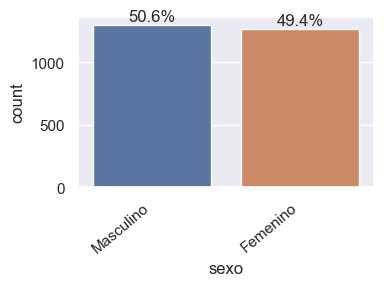

In [33]:
plt.figure(figsize=(4,3))
ax=sns.countplot(data=df_analisis,x='sexo',
                 order=df_analisis['sexo'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = len(df_analisis)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Se observa que se tiene una cantidad pareja de reclamos por parte del genero Masculino y Femenino.

**TIPO DE HOGAR**

In [34]:
groupped_data = df_analisis.groupby(['tipoHogar'],as_index=False).agg({'target': 'count'})
groupped_data.rename(columns={'target':'nro_reclamos'},inplace=True)
groupped_data.sort_values(by=['nro_reclamos'],ascending=False,inplace=True)
groupped_data["% Total"] = groupped_data['nro_reclamos']/len(df_analisis)*100
groupped_data.head(5)

,tipoHogar,nro_reclamos,% Total
0,Casa,1306,50.896337
1,Departamento,1260,49.103663


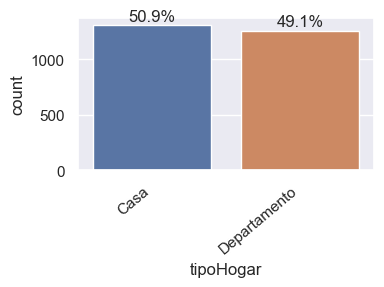

In [35]:
plt.figure(figsize=(4,3))
ax=sns.countplot(data=df_analisis,x='tipoHogar',
                 order=df_analisis['tipoHogar'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = len(df_analisis)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Se observa que se tiene una cantidad pareja (cerca del 50%) en cuanto a los reclamos emitidos por las personas que viven una casa o departamento.

**ESTADO CIVIL**

In [36]:
groupped_data = df_analisis.groupby(['estadoCivil'],as_index=False).agg({'target': 'count'})
groupped_data.rename(columns={'target':'nro_reclamos'},inplace=True)
groupped_data.sort_values(by=['nro_reclamos'],ascending=False,inplace=True)
groupped_data["% Total"] = groupped_data['nro_reclamos']/len(df_analisis)*100
groupped_data.head(5)

,estadoCivil,nro_reclamos,% Total
3,Viudo,686,26.734217
0,Casado,640,24.941543
2,Soltero,623,24.279034
1,Divorciado,617,24.045207


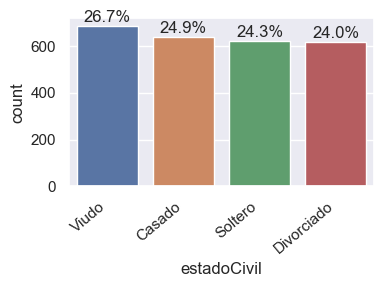

In [37]:
plt.figure(figsize=(4,3))
ax=sns.countplot(data=df_analisis,x='estadoCivil',
                 order=df_analisis['estadoCivil'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = len(df_analisis)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

- Viudo es la categoria de estado civil que tiene mayor cantidad de reclamos presentados. **Cerca del 26.7%**
- Divorciado es la categoria de estado civil que tiene menor cantidad de reclamos presentados. **Cerca del 24%**
- Aún así las categorias no presentan grandes diferencias unas de otras.

**TIPO DE TRABAJO**

In [38]:
groupped_data = df_analisis.groupby(['tipoTrabajo'],as_index=False).agg({'target': 'count'})
groupped_data.rename(columns={'target':'nro_reclamos'},inplace=True)
groupped_data.sort_values(by=['nro_reclamos'],ascending=False,inplace=True)
groupped_data["% Total"] = groupped_data['nro_reclamos']/len(df_analisis)*100
groupped_data.head(5)

,tipoTrabajo,nro_reclamos,% Total
0,Empleado,872,33.982853
1,Empresario,862,33.593141
2,Independiente,832,32.424006


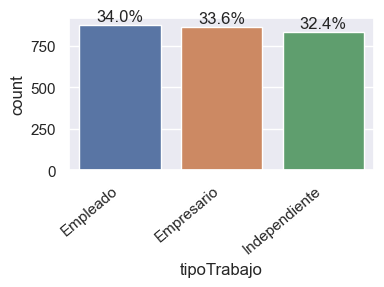

In [39]:
plt.figure(figsize=(4,3))
ax=sns.countplot(data=df_analisis,x='tipoTrabajo',
                 order=df_analisis['tipoTrabajo'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = len(df_analisis)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

- Empleado es la categoria de tipo de trabajo que tiene mayor cantidad de reclamos presentados. **Cerca del 34%**
- Independiente es la categoria de tipo de trabajo que tiene menor cantidad de reclamos presentados. **Cerca del 32%**
- Aún así las categorias no presentan grandes diferencias unas de otras.

**EDUCACION**

In [40]:
groupped_data = df_analisis.groupby(['educacion'],as_index=False).agg({'target': 'count'})
groupped_data.rename(columns={'target':'nro_reclamos'},inplace=True)
groupped_data.sort_values(by=['nro_reclamos'],ascending=False,inplace=True)
groupped_data["% Total"] = groupped_data['nro_reclamos']/len(df_analisis)*100
groupped_data.head(5)

,educacion,nro_reclamos,% Total
0,Posgrado,904,35.229930
1,Preparatoria,879,34.255651
2,Universidad,783,30.514419


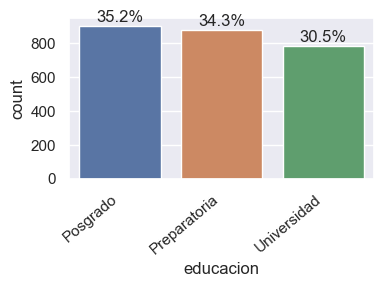

In [41]:
plt.figure(figsize=(4,3))
ax=sns.countplot(data=df_analisis,x='educacion',
                 order=df_analisis['educacion'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = len(df_analisis)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

- Posgrado es la categoria de educacion que tiene mayor cantidad de reclamos presentados. **Cerca del 35%**
- Universidad es la categoria de educacion que tiene menor cantidad de reclamos presentados. **Cerca del 30%**

**TIPO DE SEGURO**

In [42]:
groupped_data = df_analisis.groupby(['tipoSeguro'],as_index=False).agg({'target': 'count'})
groupped_data.rename(columns={'target':'nro_reclamos'},inplace=True)
groupped_data.sort_values(by=['nro_reclamos'],ascending=False,inplace=True)
groupped_data["% Total"] = groupped_data['nro_reclamos']/len(df_analisis)*100
groupped_data.head(5)

,tipoSeguro,nro_reclamos,% Total
3,Vida,665,25.915822
2,Salud,661,25.759938
1,Hogar,628,24.473889
0,Auto,612,23.850351


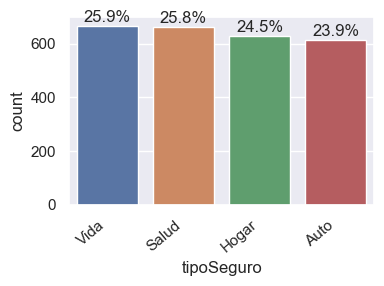

In [43]:
plt.figure(figsize=(4,3))
ax=sns.countplot(data=df_analisis,x='tipoSeguro',
                 order=df_analisis['tipoSeguro'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = len(df_analisis)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

- Vida es la categoria de tipo de seguro que tiene mayor cantidad de reclamos presentados. **Cerca del 26%**
- Auto es la categoria de tipo de seguro que tiene menor cantidad de reclamos presentados. **Cerca del 24%**
- Aún así las categorias no presentan grandes diferencias unas de otras.

**MES DE LA FECHA DE RECLAMO**

In [46]:
groupped_data = df_analisis.groupby(['mesFechaReclamo'],as_index=False).agg({'target': 'count'})
groupped_data.rename(columns={'target':'nro_reclamos'},inplace=True)
groupped_data.sort_values(by=['nro_reclamos'],ascending=False,inplace=True)
groupped_data["% Total"] = groupped_data['nro_reclamos']/len(df_analisis)*100
groupped_data.head(20)

,mesFechaReclamo,nro_reclamos,% Total
0,1,247,9.625877
1,2,237,9.236165
2,3,226,8.807482
7,8,224,8.729540
6,7,222,8.651598
8,9,213,8.300857
3,4,209,8.144973
9,10,205,7.989088
4,5,201,7.833203
10,11,200,7.794232


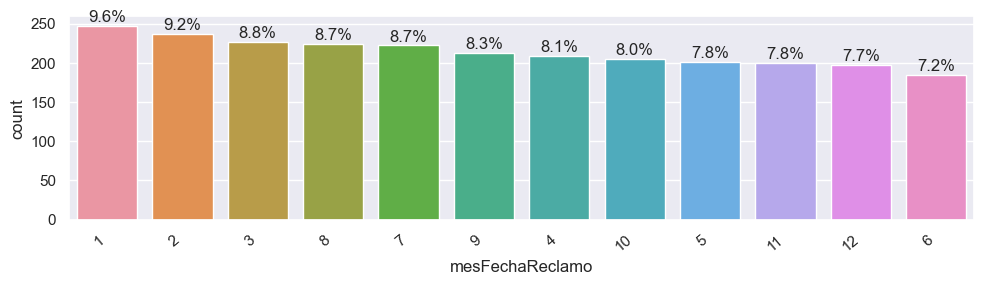

In [48]:
plt.figure(figsize=(10,3))
ax=sns.countplot(data=df_analisis,x='mesFechaReclamo',
                 order=df_analisis['mesFechaReclamo'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = len(df_analisis)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

- Enero y Febrero son los meses que presentan la mayor cantidad reclamos presentados. Cerca del 10% y 9% respectivamente.
- Diciembre y Junio son los meses que presentan la menor cantidad reclamos presentados. Cerca del 8% y 7% respectivamente.

**DIA DE SEMANA DE LA FECHA DE RECLAMO**

In [49]:
groupped_data = df_analisis.groupby(['diaSemFechaReclamo'],as_index=False).agg({'target': 'count'})
groupped_data.rename(columns={'target':'nro_reclamos'},inplace=True)
groupped_data.sort_values(by=['nro_reclamos'],ascending=False,inplace=True)
groupped_data["% Total"] = groupped_data['nro_reclamos']/len(df_analisis)*100
groupped_data.head(20)

,diaSemFechaReclamo,nro_reclamos,% Total
1,1,402,15.666407
2,2,394,15.354638
4,4,373,14.536243
0,0,360,14.029618
3,3,360,14.029618
6,6,349,13.600935
5,5,328,12.782541


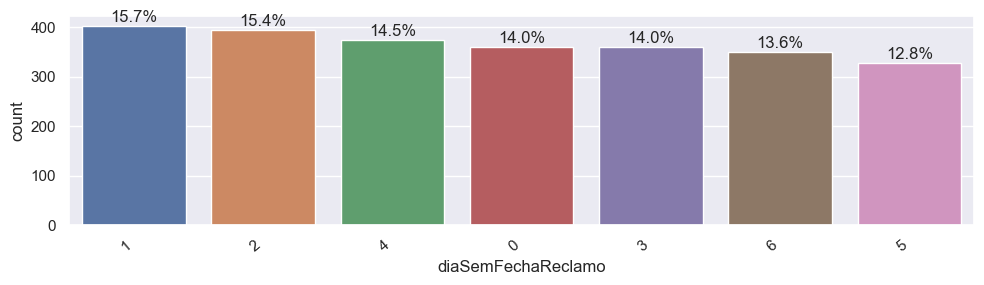

In [50]:
plt.figure(figsize=(10,3))
ax=sns.countplot(data=df_analisis,x='diaSemFechaReclamo',
                 order=df_analisis['diaSemFechaReclamo'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = len(df_analisis)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

- Martes y Miercoles son los dias de semana que presentan la mayor cantidad reclamos. Cerca del 16% en ambos dias.
- Sábado es el dia de la semana que presenta la menor cantidad de reclamos. Cerca del 12.8%.

In [44]:
df_analisis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2566 entries, 0 to 2999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   idCliente           2566 non-null   int64         
 1   sexo                2566 non-null   object        
 2   edad                2566 non-null   int64         
 3   ingreso             2566 non-null   int64         
 4   tipoHogar           2566 non-null   object        
 5   estadoCivil         2566 non-null   object        
 6   numHijos            2566 non-null   int64         
 7   puntajeCredito      2566 non-null   int64         
 8   tipoTrabajo         2566 non-null   object        
 9   educacion           2566 non-null   object        
 10  fecInicioPoliza     2566 non-null   datetime64[ns]
 11  tipoSeguro          2566 non-null   object        
 12  montoSeguro         2566 non-null   int64         
 13  fechaReclamo        2566 non-null   datetime64[n